
---

# Bio3d-vision example: _platelet-em_

---

Part of the bio3d-vision project: [bio3d-vision.github.io](bio3d-vision.github.io)

Authors: Matthew Guay (matthew.guay@nih.gov), Zeyad Emam (zeyad.emam@nih.gov)

Last updated: September 10, 2019

In [1]:
import os
import numpy as np

from collections import OrderedDict

from bio3d_vision.augment import deform
from bio3d_vision.preprocess import gen_conjugate_corners, \
    gen_corner_points, imshow, load, window_generator 
from bio3d_vision.rgb_to_index import platelet_em_rgb_map, rgb_to_index
from bio3d_vision.download_and_extract import download_and_extract


The [bio3d-vision](https://bio3d-vision.github.io) dataset collection's goal is to aggregate high-quality, large-scale 3D biological microscopy datasets whose analyses present challenging computer vision problems of great importance to advancing the state of microscopy. 

The `bio3d_vision` package can be used to simplify the integration of bio3d-vision datasets into image processing and machine learning pipelines in Python. This notebook demonstrates how to use `bio3d_vision` to download the [platelet-em](https://bio3d-vision.github.io/platelet-description.html) dataset, load data into numpy, augment it, and window it to create collections of smaller regions for use with neural networks.

---

## Download and Extract Data


Download the [platelet-em](https://bio3d-vision.github.io/platelet-description.html) dataset to a specified `download_dir`, if the dataset doesn't already exist there.

#### Download directory

Change this to specify the directory where the dataset will be downloaded. The downloading script will create a new `platelet-em` directory within it if one does not exist.

In [2]:
# Change this to change download directory
download_dir = '.'

In [3]:
bio3d_url = "https://www.dropbox.com/s/lo6i7v2mc9z2wft/images-and-labels.zip?dl=1"
bio3d_filename = "platelet-em.zip"
bio3d_md5 = 'e3a7bb0b0099220781bfea3e5ee9430c'

if not os.path.exists(os.path.join(download_dir, 'platelet-em')):
    print('No platelet-em dataset found, downloading...')
    download_and_extract(
        bio3d_url, 
        download_dir, 
        filename=bio3d_filename,
        md5=bio3d_md5)

else:
    print('Found `platelet-em` dataset already in ' + download_dir)

0it [00:00, ?it/s]

No platelet-em dataset found, downloading...


100%|█████████▉| 95600640/95753458 [00:31<00:00, 2887715.56it/s]

Extracting /home/matt/Desktop/platelet-em/platelet-em.zip to /home/matt/Desktop/platelet-em


---

## Load Data

Load the 50x800x800 image and semantic label datasets

### File paths

In [4]:
# Paths to image and semantic label data
main_data_dir = os.path.join(download_dir, 'platelet-em')
raw_data_dir = os.path.join(main_data_dir, 'images')
raw_data_file = '50-images.tif'
label_data_dir = os.path.join(main_data_dir, 'labels-semantic')
label_data_file = '50-semantic.tif'

### Load into numpy

In [5]:
# Load raw and label data
raw_data = load(raw_data_dir, raw_data_file)

# Specify Data Type when loading label data
label_data = load(label_data_dir, label_data_file, data_type=np.int32)

# Label data is provided in RGB format (0-255). Convert to indices (0-7) as follows:
# First get the mapping from RGB to index
label_data = rgb_to_index(label_data, platelet_em_rgb_map)

95756288it [00:50, 2887715.56it/s]                              

### Visualize

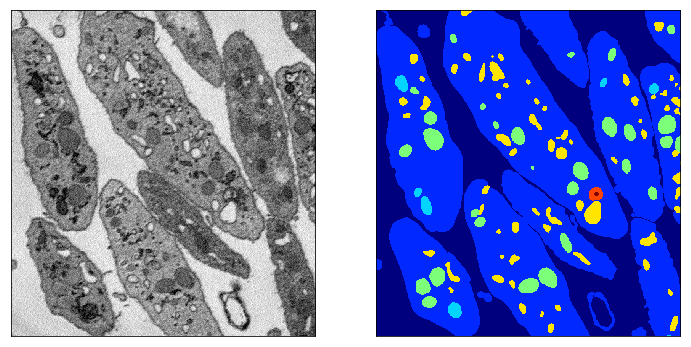

In [6]:
# Show sample image (first image in each stack)
images = OrderedDict()
images[0] = raw_data[0]
images[1] = label_data[0]

plot_settings = OrderedDict()
plot_settings[0] = {'cmap': 'gray'}
plot_settings[1] = {'cmap':'jet', 'vmin':0, 'vmax':label_data.max()}

imshow(images, (12, 6), plot_settings)

---

## Data Augmentation: Elastic Deformation

We provide code for elastic deformation. The user will likely want to add other common data augmentation and data normalization techniques. 

In [7]:
# Set deformation settings
deformation_settings = dict()
# TODO: Explain these
deformation_settings['scale'] = 40
deformation_settings['alpha'] = 20
deformation_settings['sigma'] = 0.6

# Choose deformation random seed (this is important to make sure both raw 
# and label data are deformed the same)
deformation_random_seed = 1

# Perform elastic deformation
deformed_raw_data = deform(raw_data,
                           random_seed=deformation_random_seed)

deformed_label_data = deform(label_data,
                             random_seed=deformation_random_seed)

### Visualize

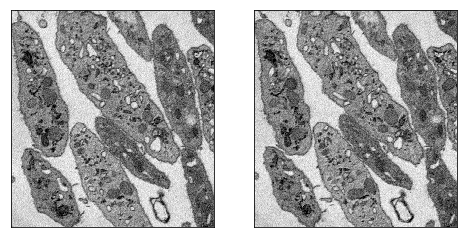

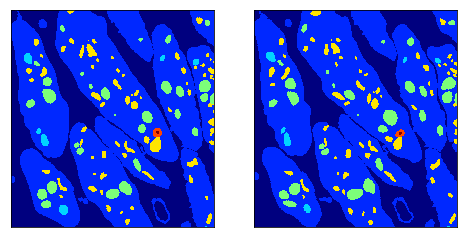

In [8]:
# Show effect of deformations
images = OrderedDict()
images[0] = raw_data[0]
images[1] = deformed_raw_data[0]

plot_settings = OrderedDict()
plot_settings[0] = {'cmap': 'gray'}
plot_settings[1] = {'cmap':'gray'}

imshow(images, (8, 4), plot_settings)

images = OrderedDict()
images[0] = label_data[0]
images[1] = deformed_label_data[0]

plot_settings = OrderedDict()
plot_settings[0] = {'cmap':'jet', 'vmin':0, 'vmax':label_data.max()}
plot_settings[1] = {'cmap':'jet', 'vmin':0, 'vmax':label_data.max()}

imshow(images, (8, 4), plot_settings)

---

## Windowing

We supply functionalities for random windowing as well as generating two windows of different shape centered at the same location (in case input and output of neural networks are different shapes). 

In [9]:
# Fix the windowing parameters
random_windowing = True
corner_generation_seed = 1
label_window_shape = [5, 100, 200] # corresponds to the shape output by the neural network (smaller than input)
window_spacing = [5, 50, 100] # implies there will be no overlap in z but half the image will overlap in x and y.
corner_generation_random_seed = None

# Generate a list of corner points for the labels
label_corner_points = gen_corner_points(spatial_shape=deformed_label_data.shape,
                                  window_spacing=window_spacing,
                                  window_shape=label_window_shape,
                                  random_windowing=random_windowing,
                                  random_seed=corner_generation_random_seed)

raw_window_shape = [5, 200, 400] # corresponds to the shape input to the neural network (larger than output)
# We choose a much larger raw_window_shape to illustrate what's going on

# Generate a list of corner poins for the raw inputs

raw_corner_points = gen_conjugate_corners(corner_points=label_corner_points,
                                          window_shape=label_window_shape,
                                          conjugate_window_shape=raw_window_shape)

In [10]:
# Perform windowing
raw_window_generator = window_generator(deformed_raw_data,
                                        window_shape=raw_window_shape,
                                        corner_points=raw_corner_points)
label_window_generator = window_generator(deformed_label_data,
                                          window_shape=label_window_shape,
                                          corner_points=label_corner_points)

### Visualization: Example 1

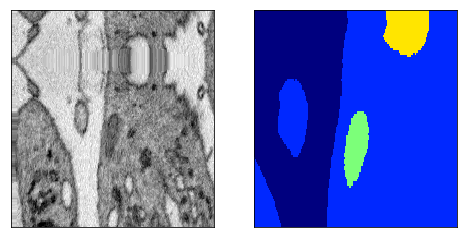

In [11]:
# Show sample windows (first image in each stack)
# Notice the mirroring on the left in the raw window!
images = OrderedDict()
images[0] = next(raw_window_generator)[0]
images[1] = next(label_window_generator)[0]

plot_settings = OrderedDict()
plot_settings[0] = {'cmap': 'gray'}
plot_settings[1] = {'cmap':'jet', 'vmin':0, 'vmax':label_data.max()}

imshow(images, (8, 4), plot_settings)

### Visualization: Example 2

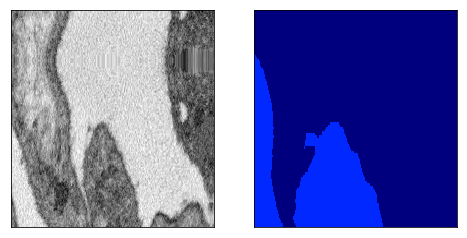

In [12]:
# We also plot another set of windows here
# Show sample windows (first image in each stack)
# Notice the mirroring on the left in the raw window!
images = OrderedDict()
for _ in range(5):
    images[0] = next(raw_window_generator)[0]
    images[1] = next(label_window_generator)[0]

plot_settings = OrderedDict()
plot_settings[0] = {'cmap': 'gray'}
plot_settings[1] = {'cmap':'jet', 'vmin':0, 'vmax':label_data.max()}

imshow(images, (8, 4), plot_settings)